# Tridiagonal Matrix Systems

Tridiagonal matrix systems are common in machine learning, signal processing and control. We saw an example of such systems in the previous tutorial on [total variation denoising](14_total_variation.ipynb). An $n$-by-$n$ tridiagonal system can be expressed as,

$$
Ax = d
$$

where $A$ has the form

$$
A = \begin{bmatrix}
        b_1 & c_1 & & & 0 \\
        a_2 & b_2 & c_2 & \phantom{\ddots} & 0 \\
		& a_3 & b_3 & \ddots & \\
		& & \ddots & \ddots & c_{n-1} \\
		0 & & & a_{n} & b_n 
\end{bmatrix}
$$

Assuming $A$ is full rank we can obtain the solution $x = A^{-1} d$ using standard techniques such as Gaussian elimination or LU-decomposition. When the matrix $A$ is diagonally dominant or positive definite then faster techniques such as the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm) can be used. However, the Thomas algorithm is iterative so only good for single-threaded hardware or when batch sizes are large (so that each system in the batch can be solved in parallel). A more sophisticated algorithm based on [cyclic reduction](https://en.wikipedia.org/wiki/Cyclic_reduction) can be used to parallelize the solution of tridiagonal systems. This algorithm works by repeatedly eliminating odd and even rows from $A$ resulting in two independent half-size systems that can be solved in parallel, recursively applying cyclic reduction on each system.


## Differentiable tridiagonal solvers

Since we can write the solution in closed form, i.e., $x = A^{-1} d$, it is straightforward to derive gradients in the backward pass of a neural network containing tridiagonal systems. Let $v^T = \frac{\text{d} L}{\text{d} x}$ and $w^T = v^T A^{-1}$. Then we have

$$
\begin{align*}
\frac{\text{d} L}{\text{d} d} &= w^T \\
\frac{\text{d} L}{\text{d} b} &= -w^T \odot x^T \\
\frac{\text{d} L}{\text{d} a} &= -w_{2:n}^T \odot x_{1:n-1}^T \\
\frac{\text{d} L}{\text{d} c} &= -w_{1:n-1}^T \odot x_{2:n}^T
\end{align*}
$$

where $\odot$ is the Hadamard (i.e., elementwise) product. The last three expressions can be derived by recognizing that

$$
\begin{align*}
\frac{\text{d} L}{\text{d} A_{ij}}
&= \frac{\text{d} L}{\text{d} x} \frac{\text{d} x}{\text{d} A_{ij}} \\
&= v^T \frac{\text{d} A^{-1} d}{\text{d} A_{ij}} \\
&= -v^T A^{-1} \frac{\text{d} A}{\text{d} A_{ij}} A^{-1} d \\
&= -w^T E_{ij} x \\
&= -w_i x_j.
\end{align*}
$$

where the third line uses the identity for derivative of the inverse of a matrix. We can obtain $w$ by solving $A^T w = v$. Importantly, we can reuse any factorization of $A$ in the forward pass to reduce computational effort in the backward pass, or simply reapply a fast solution method such as the Thomas algorithm or cyclic reduction. Using the latter, the backward pass takes (approximately) the same amount of compute as the forward pass.


In [1]:
%matplotlib inline

import torch
from torch import optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(torch.__version__)
print("device {} will be used".format(device))

2.1.0
device cpu will be used


## Profiling

We will use the example of [total variation denoising](14_total_variation_denoising.ipynb) to profile different implementations of tridiagonal solvers. Note that in this case the matrix $A$ is symmetric (i.e., $a = c$). Here we are only profiling the forward pass (since the backward pass for the total variation problem is a pass through operation). Since PyTorch does not provide a native implementation we have written our own version. We compare against the standard linear equation solver (`torch.linalg.solve`) and via Cholesky factorization for different batch and problem sizes. As we will see, the standard solvers (which have been heavily optimized within PyTorch) are very competitive and modern hardware when batches or problems are small. Specialized solvers excel when batches or problems get large.


In [3]:
import time
import sys
sys.path.append("../")

from ddn.pytorch.tridiagsolve import tridiagsolve


def tvsolver(x, lmd, maxiters=100, solver='linalg'):
    """
    Pytorch solver for the 1D total variation denoising problem. Operates on a batch of inputs
    x of size (b, n) all with same lambda. Solver can be 'linalg', 'cholesky', 'tridiagthomas',
    'tridiagcyclic'.
    """

    # initialize u to x
    b, n = x.shape
    u = x.clone()
    
    # iterate
    Dx = (x[:, :-1] - x[:, 1:]).view(b, n - 1, 1)
    neg_ones = -1.0 * torch.ones((b, n - 2), dtype=x.dtype, device=x.device)    
    for _ in range(maxiters):
        L = torch.abs(u[:, :-1] - u[:, 1:]) / lmd
        
        if solver == 'linalg':
            H = torch.diag_embed(L + 2.0) + torch.diag_embed(neg_ones, offset=1) + torch.diag_embed(neg_ones, offset=-1)
            w = torch.linalg.solve(H, Dx)
        elif solver == 'cholesky':
            H = torch.diag_embed(L + 2.0) + torch.diag_embed(neg_ones, offset=1) + torch.diag_embed(neg_ones, offset=-1)
            w = torch.cholesky_solve(Dx, torch.linalg.cholesky(H))
        elif solver == 'tridiagcyclic':
            w = tridiagsolve(L + 2.0, neg_ones, neg_ones, Dx, method='cyclic')
        elif solver == 'tridiagthomas':
            w = tridiagsolve(L + 2.0, neg_ones, neg_ones, Dx, method='thomas')
        else:
            print("Unknown method: {}".format(solver))
            return x
        
        u = x.clone()
        u[:, 1:] += w.view(b, n - 1)
        u[:, :-1] -= w.view(b, n - 1)
        
    return u


# experiment setup
torch.manual_seed(0)
methods = ['linalg', 'cholesky', 'tridiagthomas', 'tridiagcyclic']
exprs = {
    'by_batch' : [(1, 256), (10, 256), (100, 256), (1000, 256)],
    'by_signal_length' : [(1, 64), (1, 128), (1, 256), (1, 512), (1, 1024)]
}

# run experiments
elapsed_time = {k: [[] for j in range(len(exprs[k]))] for k in exprs}
for i, k in enumerate(exprs):
    for j, (b, s) in enumerate(exprs[k]):
        # generate signal
        x = (torch.floor(torch.linspace(-5, 5, s)).view(1, s).repeat(b, 1) + \
            0.5 * torch.randn((b, s), dtype=torch.float32)).to(device)
        
        # find denoised signal
        for m in methods:
            print("profiling '{}' on input of size {}...".format(m, (b, s)), end='\r')
            # profile
            start = time.time()
            u = tvsolver(x, 10.0, 100, m)
            elapsed_time[k][j].append(time.time() - start)

    print(elapsed_time[k])

print("Done.")

[[0.2988710403442383, 0.05745100975036621, 2.019347667694092, 0.08419442176818848], [0.30745482444763184, 0.28026723861694336, 2.5934691429138184, 0.13468408584594727], [3.3263895511627197, 3.040201187133789, 3.650071859359741, 0.18850922584533691], [25.522920608520508, 46.511597871780396, 2.7463231086730957, 1.296722650527954]]
[[0.015673398971557617, 0.03155827522277832, 0.49911022186279297, 0.08276534080505371], [0.020987749099731445, 0.04229736328125, 1.0198423862457275, 0.08311057090759277], [0.19519853591918945, 0.0523066520690918, 2.4532077312469482, 0.09502673149108887], [0.45531129837036133, 0.1985795497894287, 6.446474313735962, 0.12085866928100586], [0.8849658966064453, 0.43800997734069824, 10.210390567779541, 0.12988996505737305]]
Done.


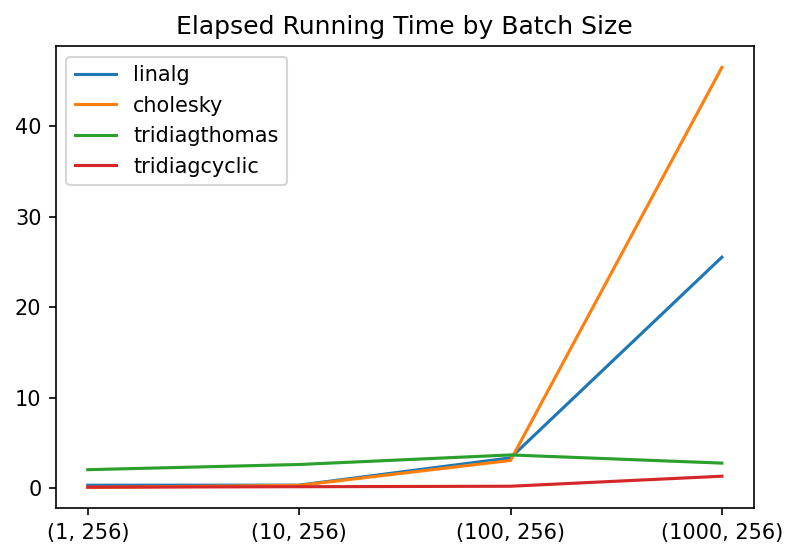

In [4]:
# plot results by batch

plt.figure(figsize=(6, 4), dpi=150)
plt.plot(elapsed_time['by_batch'])
plt.gca().set_xticks(range(len(exprs['by_batch'])))
plt.gca().set_xticklabels(exprs['by_batch'])
plt.title('Elapsed Running Time by Batch Size')
plt.legend(methods)
plt.show()

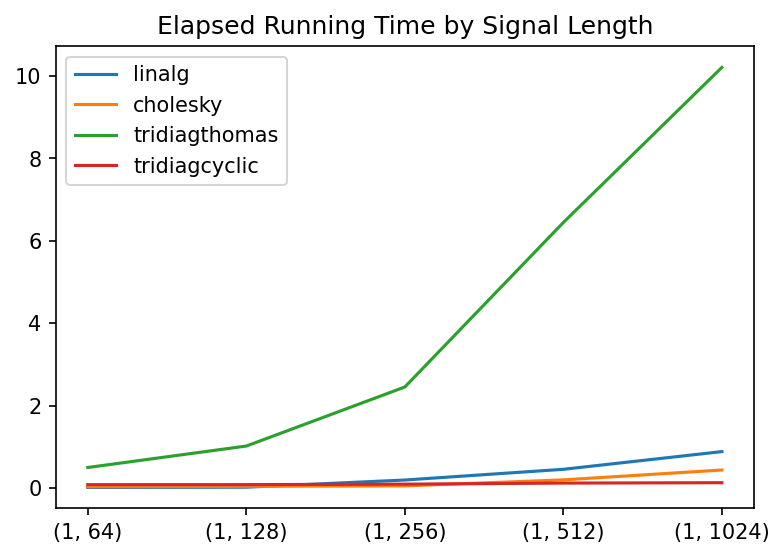

In [5]:
# plot results by signal length

plt.figure(figsize=(6, 4), dpi=150)
plt.plot(elapsed_time['by_signal_length'])
plt.gca().set_xticks(range(len(exprs['by_signal_length'])))
plt.gca().set_xticklabels(exprs['by_signal_length'])
plt.title('Elapsed Running Time by Signal Length')
plt.legend(methods)
plt.show()

## Learning Example

Let's now demonstrate how to use our differentiable tridiagonal solver, implemented in `TriDiagSolveFcn`, to learn the parameters of a tridiagonal matrix. We will initialize the parameters of the matrix and righthand side randomly. We'll then learn $a$ and $c$ such that the solution $Ax = d$ gives $x = 1_n$.

         a_initial: tensor([-0.2577, -0.0752, -0.3647, -0.1889, -0.9270, -0.2033, -0.3066])
         c_initial: tensor([-0.5082, -0.1552, -0.2035, -0.2370, -0.0803, -0.0464, -0.3889])
         x_initial: tensor([0.2840, 0.3946, 0.2905, 0.3417, 0.4354, 0.4891, 0.4016, 0.4642])
           a_final: tensor([-0.7688, -0.8491, -0.9494, -0.7388, -1.1895, -0.7244, -1.1993])
           c_final: tensor([-1.8452, -0.7186, -0.7440, -0.7861, -0.6422, -0.4729, -0.9389])
           x_final: tensor([0.9965, 1.0009, 1.0013, 1.0030, 1.0018, 1.0013, 0.9996, 0.9985])
A_final @ x_target: tensor([0.4653, 0.7679, 0.5128, 0.5767, 0.8791, 0.7630, 0.6491, 0.8140])
 A_final @ x_final: tensor([0.4556, 0.7718, 0.5125, 0.5810, 0.8802, 0.7641, 0.6486, 0.8115])
            d_true: tensor([0.4556, 0.7718, 0.5125, 0.5810, 0.8802, 0.7641, 0.6486, 0.8115])


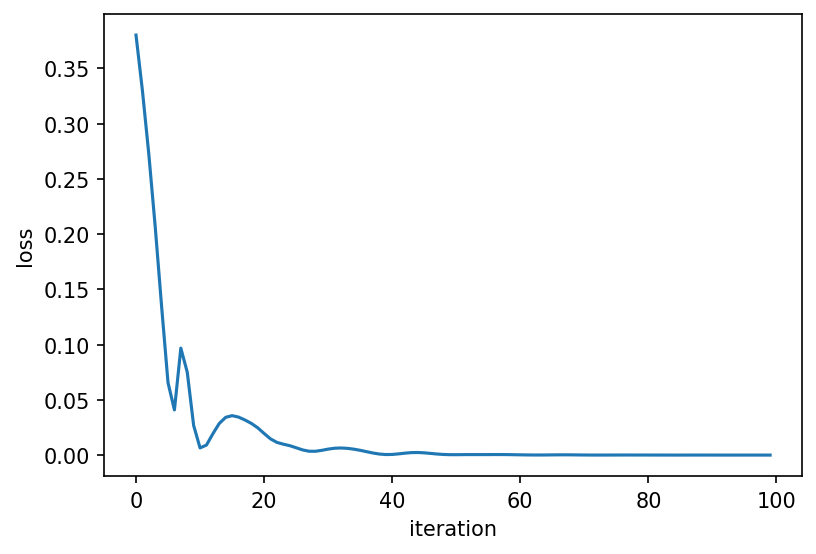

In [6]:
import sys
sys.path.append("../")

from ddn.pytorch.tridiagsolve import TriDiagSolveFcn

N = 8

b = 2.0 * torch.ones((1, N), device=device) + 0.5 * torch.rand((1, N), device=device)
a = torch.nn.Parameter(-1.0 * torch.rand((1, N-1), device=device, requires_grad=True))
c = torch.nn.Parameter(-1.0 * torch.rand((1, N-1), device=device, requires_grad=True))
d = torch.rand((1, N, 1), device=device)

x_target = torch.ones((1, N, 1), device=device)

# print initial values
print("         a_initial: {}".format(a.detach().flatten()))
print("         c_initial: {}".format(c.detach().flatten()))
x = TriDiagSolveFcn.apply(b, a, c, d)
print("         x_initial: {}".format(x.detach().flatten()))

opt = torch.optim.AdamW([a, c], lr=0.1)

# do optimisation
loss_fcn = torch.nn.MSELoss()
history = []
for _ in range(100):
    opt.zero_grad(set_to_none=True)
    x = TriDiagSolveFcn.apply(b, a, c, d)
    loss = loss_fcn(x, x_target)
    loss.backward()
    opt.step()
    
    history.append(loss.item())

# show final values
print("           a_final: {}".format(a.detach().flatten()))
print("           c_final: {}".format(c.detach().flatten()))
x = TriDiagSolveFcn.apply(b, a, c, d)
print("           x_final: {}".format(x.detach().flatten()))

# check solution
A = torch.diag_embed(b) + torch.diag_embed(a, offset=-1) + torch.diag_embed(c, offset=1)
print("A_final @ x_target: {}".format((A @ x_target).detach().flatten()))
print(" A_final @ x_final: {}".format((A @ x).detach().flatten()))
print("            d_true: {}".format(d.detach().flatten()))

# plot learning curve
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()